In [1]:
import numpy as np
import uproot
import pandas as pd
import matplotlib.pyplot as plt

import os

# given "uproot_io.py" at the start of the project to help handle files
from UG_Project_Raw.uproot_io import Events, View

In [7]:
# A non-corrupt copy of the cheated_0 file from the raw folder
events = Events("CheatedRecoFile_0_new.root")

# The Monte-Carlo PDG is a universel numbering scheme for all particles
# This dictionary was created by cross-referencing np.unique(events.mc_pdg) with the pdg codes
# !! no connection right now, find link to the paper
mc_pdg_dict = {
    -2212: "Anti proton",
    -321: "K-",
    -211: "π-",
    -13: "μ-",
    -11: "e- ",
    11: "e+",
    13: "μ+",
    22: "γ",
    211: "π+",
    321: "K+",
    2212: "proton",
    3112: "Σ-",
    3222: "Σ+",
    
    # Light Nuclei
    1000010020: "Deuteron",
    1000010030: "Triton",
    1000010040: "Helium-3",
    1000020030: "Helium-3 (alt)",
    1000020040: "Alpha Particle (He-4)",
    1000020060: "Helium-6",
    1000030060: "Lithium-6",
    1000030070: "Lithium-7",
    1000030080: "Lithium-8",
    1000040080: "Beryllium-8",
    1000040090: "Beryllium-9",
    1000040100: "Beryllium-10",
    1000070150: "Nitrogen-15",
    1000070160: "Nitrogen-16",
    1000070170: "Nitrogen-17",
    
    # Heavier Nuclei
    1000100200: "Neon-20",
    1000100220: "Neon-22",
    1000110230: "Sodium-23",
    1000120240: "Magnesium-24",
    1000120250: "Magnesium-25",
    1000120260: "Magnesium-26",
    1000120270: "Magnesium-27",
    1000120280: "Magnesium-28",
    1000130260: "Aluminum-26",
    1000130270: "Aluminum-27",
    1000130280: "Aluminum-28",
    1000130290: "Aluminum-29",
    1000140270: "Silicon-27",
    1000140280: "Silicon-28",
    1000140290: "Silicon-29",
    1000140300: "Silicon-30",
    1000140310: "Silicon-31",
    1000140320: "Silicon-32",
    1000140330: "Silicon-33",
    1000140340: "Silicon-34",
    1000150300: "Phosphorus-30",
    1000150310: "Phosphorus-31",
    1000150320: "Phosphorus-32",
    1000150330: "Phosphorus-33",
    1000150340: "Phosphorus-34",
    1000150350: "Phosphorus-35",
    1000150360: "Phosphorus-36",
    1000150370: "Phosphorus-37",
    1000160310: "Sulfur-31",
    1000160320: "Sulfur-32",
    1000160330: "Sulfur-33",
    1000160340: "Sulfur-34",
    1000160350: "Sulfur-35",
    1000160360: "Sulfur-36",
    1000160370: "Sulfur-37",
    1000160380: "Sulfur-38",
    1000160390: "Sulfur-39",
    1000170340: "Chlorine-34",
    1000170350: "Chlorine-35",
    1000170360: "Chlorine-36",
    1000170370: "Chlorine-37",
    1000170380: "Chlorine-38",
    1000170390: "Chlorine-39",
    1000170400: "Chlorine-40",
    1000180350: "Argon-35",
    1000180360: "Argon-36",
    1000180370: "Argon-37",
    1000180380: "Argon-38",
    1000180390: "Argon-39",
    1000180400: "Argon-40",
    1000180410: "Argon-41",
    1000190380: "Potassium-38",
    1000190390: "Potassium-39",
    1000190400: "Potassium-40",
    1000190410: "Potassium-41",
}

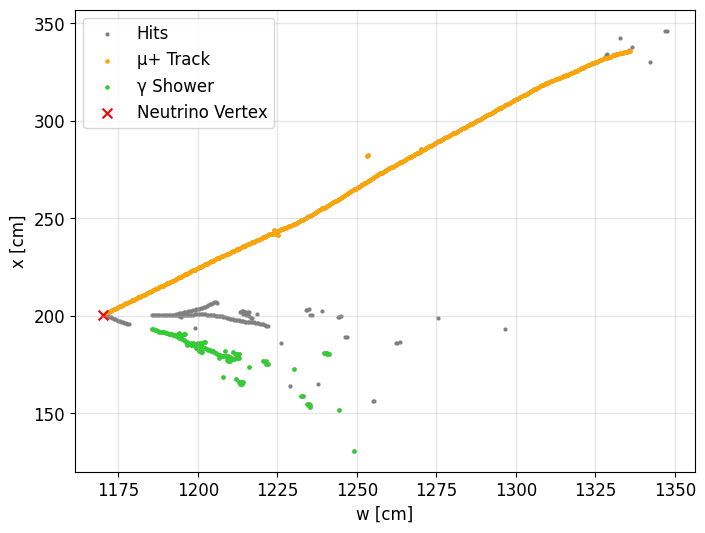

In [8]:
# Example event
def plot_event(events, event_number):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    event_indices = np.split(np.arange(len(identifiers)), change_indices)[event_number]

    # abort if the event is too small
    if event_indices.size < 3:
        print(f"Event {event_number} too small")
        return
    w_hits = np.concatenate(events.reco_hits_w[event_indices])
    x_hits = np.concatenate(events.reco_hits_x_w[event_indices])

    # Choose the indices SPECIFICALLY in the case of event no.65
    # => not every event has tracks at [1] and [10]
    w_track = events.reco_hits_w[event_indices[1]]
    x_track = events.reco_hits_x_w[event_indices[1]]

    w_shower = events.reco_hits_w[event_indices[10]]
    x_shower = events.reco_hits_x_w[event_indices[10]]

    pdg_track = events.mc_pdg[event_indices[1]]
    pdg_shower = events.mc_pdg[event_indices[10]]

    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize = (8,6))
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    plt.scatter(w_hits, x_hits, s=4, c='grey', label='Hits')
    plt.scatter(w_track, x_track, s=5, c='orange', label=f'{mc_pdg_dict[pdg_track]} Track')
    plt.scatter(w_shower, x_shower, s=5, c='limegreen', label=f'{mc_pdg_dict[pdg_shower]} Shower')
    plt.scatter(events.neutrino_vtx_w[event_indices[0]], events.neutrino_vtx_x[event_indices[0]], marker='x', s=50, c='#F00', label='Neutrino Vertex')
    plt.xlabel('w [cm]')
    plt.ylabel('x [cm]')
    plt.legend()
    plt.show()
# there are ~9500 events here
# event 65 gives a nice comparison of track and shower
plot_event(events, 65)


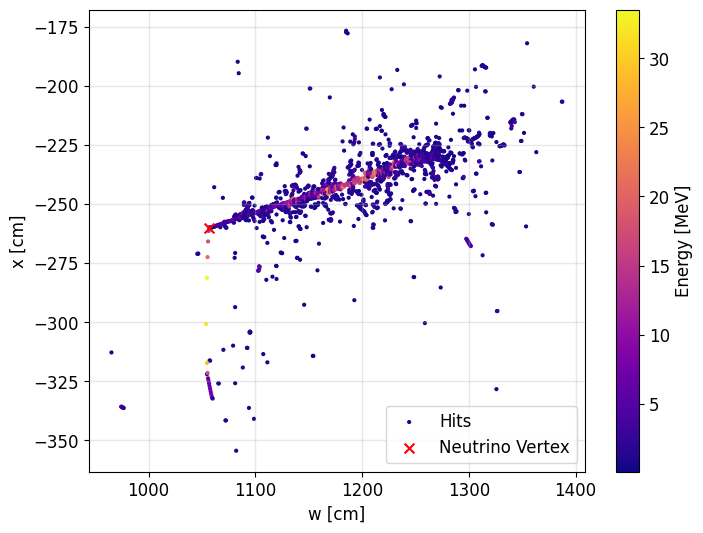

In [10]:
# Visual of the energy dispersion across an event
def plot_event_adc(events, event_number):
    # since each "event.number" isnt unique, we need to split along each event number
    # this is what we call "identifiers"
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    event_indices = np.split(np.arange(len(identifiers)), change_indices)[event_number]
    adcs = np.concatenate(events.reco_adcs_w[event_indices])
    adcs = 0.0075 * adcs # <- conversion between ADCs and MeVs

    if event_indices.size < 3:
        print(f"Event {event_number} too small")
        return
    
    # following two arrays are the event hits
    w_hits = np.concatenate(events.reco_hits_w[event_indices])
    x_hits = np.concatenate(events.reco_hits_x_w[event_indices])

    norm = plt.Normalize(vmin=np.min(adcs), vmax=np.max(adcs))
    cmap = plt.get_cmap('plasma')
    
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize = (8,6))
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    scatter = plt.scatter(w_hits, x_hits, s=4, c=adcs, cmap=cmap, label='Hits', norm=norm)
    plt.scatter(events.neutrino_vtx_w[event_indices[0]], events.neutrino_vtx_x[event_indices[0]], marker='x', s=50, c='#F00', label='Neutrino Vertex')
    plt.xlabel('w [cm]')
    plt.ylabel('x [cm]')
    plt.colorbar(scatter, label='Energy [MeV]')
    plt.legend()
    plt.show()

plot_event_adc(events, 1427) # <- another good example of an EM shower
# can see the characteristic spread as the decays both exponentiate and lose energy